##Library

In [1]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
!pip install konlpy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
import numpy as np
# 데이터를 다루는 가장 기본이 되는 라이브러리
import pandas as pd
# 데이터를 엑셀의 형태로 보여주는 라이브러리
import keras
# 생성자를 임포트하기 위한 라이브러리
from tensorflow.keras import models, layers, optimizers, callbacks
# 케라스는 인공신경망을 쉽게 사용할 수 있게 개발된 라이브러리
import seaborn as sns
# 시각화 관련 라이브러리
import matplotlib.pyplot as plt
# 그래프 관련 라이브러리
from sklearn.metrics import confusion_matrix, classification_report
# 분류 문제 모델 성능 평가에 사용되는 컨퓨전 행렬 함수, 분류모델 성능지표 레포트  
from sklearn import preprocessing
# scikit-learn의 전처리 라이브러리
from tensorflow.keras.utils import to_categorical
# 범주형 변수를 one-hot encoding 해주는 함수

In [4]:
from collections import Counter
# 단어의 빈도를 계산하기 위한 라이브러리
import transformers
from transformers import AutoTokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
# 문장을 인덱스로 변환하기 위한 라이브러리
import tensorflow as tf
import os
# 시스템 제어를 돕는 라이브러리
os.environ['CUDA_VISIBLE_DEVICES']='0'
# GPU가 여럿 존재하는 환경에서 0번 GPU만을 사용

In [5]:
# 데이터 로드를 위해 구글 드라이브 마운트
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


##Data Load & Preprocessing##

In [6]:
# 데이터 로드
train_data = pd.read_csv('/content/drive/MyDrive/산업인공지능/박시우/preprocessed_train.CSV',encoding='cp949', index_col=0)
test_data = pd.read_csv('/content/drive/MyDrive/산업인공지능/박시우/preprocessed_test.CSV',encoding='cp949', index_col=0)

In [7]:
# 학습 & 테스트 데이터 정의
train_x = train_data['문장']
test_x = test_data['문장']
train_y = train_data['class']
test_y = test_data['class']

In [8]:
train_y.value_counts() # -> 클래스 불균형 문제 파악
# 압도적으로 1에 해당하는 행의 수가 많음

1    6625
0    3014
2    2519
Name: class, dtype: int64

In [9]:
# 필요 모듈 임포트
import imblearn
print(imblearn.__version__)
from collections import Counter


# 필요 함수 정의
def count_and_plot(y): 
    counter = Counter(y)
    for k,v in counter.items():
        print('Class=%d, n=%d (%.3f%%)' % (k, v, v / len(y) * 100))
    plt.bar(counter.keys(), counter.values())
    plt.show()

0.8.1


Class=0, n=3014 (24.790%)
Class=1, n=6625 (54.491%)
Class=2, n=2519 (20.719%)


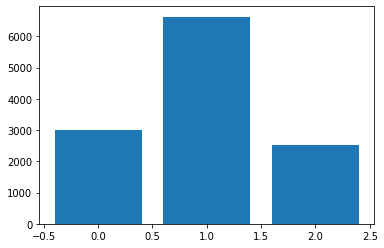

In [10]:
count_and_plot(train_y)
# 1에 해당하는 클래스가 제일 많음 -> 클래스 불균형 문제

Class=1, n=2016 (53.947%)
Class=2, n=786 (21.033%)
Class=0, n=935 (25.020%)


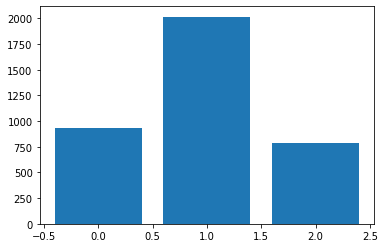

In [11]:
count_and_plot(test_y)

In [12]:
# 데이터 량
row_train,  = np.shape(train_x)
row_test,  = np.shape(test_x)
row_train,  = np.shape(train_y)
print('train data: {}, test data: {}, # of classes: {}'.format(row_train, row_test, 3))

train data: 12158, test data: 3737, # of classes: 3


In [13]:
train_x

0
0        일      안      하는      시간      쉬      싶어서      ...
1        아동      성범죄      폐      버      기록      바      ...
2        루나      솔로      앨범      나왔을      때      메모    ...
3        홍      박      어버이연합      보내요      뭐      이런   ...
4        놔      왜      여기      댓글      여자      김치      ...
                               ...                        
12153    똥      고충      에이즈      전파      범      므      ...
12154    문재인      찍고      토착      왜구      물러나라      하게 ...
12155    굳           세워라      갓      건배      모든      남 ...
12156    국제      결혼      한몫      봄      똥      남아      ...
12157                                                와꾸한남콘
Name: 문장, Length: 12158, dtype: object

In [14]:
test_x

0       진짜      죽어도      상관없다는           마인드      싸웠더니...
1       여자      취미      애      낳는      건      가      취...
2       개슬람녀      필요      없고           네      엄마      ...
3       조팔      남한      길거리      돌아다니면      한국      남자...
4       바지      리다      한남      와      꾸      보고      ...
                              ...                        
3732    저      시대      언어      면      한      남충      시...
3733    다른      것      눈      어떻게           생기      노 ...
3734    막노동      해도      한국      살      말      미쳤다고   ...
3735    사형      구형      하였으나      여성      점      감안   ...
3736    참      군      남      노      남자      용도      고기...
Name: 문장, Length: 3737, dtype: object

In [15]:
# 불용어(숫자, 특수문자) 제거로 nan이 된 데이터에 의미없는 문자 할당 
for i in range(row_train):
  if type(train_x[i]) is float:
    train_x[i] = '름'
for i in range(row_test):
  if type(test_x[i]) is float:
    test_x[i] = '름'

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


In [16]:
# 다중 공백 제거 -> 단일 공백
for i in range(row_train):
  train_x[i] = ' '.join(train_x[i].split())
for i in range(row_test):
  test_x[i] = ' '.join(test_x[i].split())

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


In [17]:
# 불용어 제거를 위해 리스트로 변환
for i in range(row_train):
  train_x[i] = train_x[i].split(' ')
for i in range(row_test):
  test_x[i] = test_x[i].split(' ')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


In [18]:
test_x[3734]

['막노동', '해도', '한국', '살', '말', '미쳤다고', '남미', '가냐', '차', '라리', '자살', '하겠다']

In [19]:
# 개발자 지정 불용어 삭제
stop_words = "진짜 지금 아니나 그냥 자기 그런가 어떻 어떻게 저렇 저렇게 아닌가 한다고 거지 무슨 씨 보면 대 만 거 안 임 등 장 너 아니냐 함 네 저런 애 이 게 때 일 글 기 지 더 노 나 이런 후 해야 하나 우리 난 또 만 와 해 좀 하는 그런 안 그 더 된 고 하지 하고 해서 면 뭐 건 가 있다 된거 합니다 등 했더니 익 관련 이미 수 있으면 된다 하는데 하면 왜 여기 먼저 하니까 보네 다시 있을 거임 걸 저런 딱히 대해 어디 아니 솔직히 이제 해봐야 하자 하노 있을까 그럼 역시 되나 하니 되어 갔는데 하러 근처 곧 같아서 않냐 해주고 언제 싶다 완전 하여 나도 무슨 하자고 된다는 있는 더욱 해봤자 어차피 라서 한다 된다 해주는 하기 있으면 해줘도 반드시 이지 다는 대해 "
stop_words = stop_words.split(' ')
for i in range(row_test):
  for w in test_x[i]:
    if w in stop_words:
      test_x[i].remove(w)
for i in range(row_train):
  for w in train_x[i]:
    if w in stop_words:
      train_x[i].remove(w)

In [20]:
test_x[3734]

['막노동', '해도', '한국', '살', '말', '미쳤다고', '남미', '가냐', '차', '라리', '자살', '하겠다']

In [21]:
test_x = test_x.astype('string')
train_x = train_x.astype('string')

In [22]:
# 리스트를 문자로 바꿔 생긴 특수기호([,']) 삭제
punct = "/-'?!.,#$%\'()*+-/:;<=>@[\\]^_`{|}~[]" + '""“”’' + '∞θ÷α•à−β∅³π‘₹´°£€\×™√²—–&'
punct_mapping = {"‘": "'", "₹": "e", "´": "'", "°": "", "€": "e", "™": "tm", "√": " sqrt ", "×": "x", "²": "2", "—": "-", "–": "-", "’": "'", "_": "-", "`": "'", '“': '"', '”': '"', '“': '"', "£": "e", '∞': 'infinity', 'θ': 'theta', '÷': '/', 'α': 'alpha', '•': '.', 'à': 'a', '−': '-', 'β': 'beta', '∅': '', '³': '3', 'π': 'pi', }

def clean_punc(text, punct, mapping):
    for p in mapping:
        text = text.replace(p, "")
    
    for p in punct:
        text = text.replace(p, '')
    
    specials = {'\u200b': ' ', '…': ' ... ', '\ufeff': '', 'करना': '', 'है': ''}
    for s in specials:
        text = text.replace(s, '')
    
    return text.strip()
#test data 문장
for i in range(row_test):
  test_x[i] = clean_punc(str(test_x[i]), punct, punct_mapping)
#test data 문장
for i in range(row_train):
  train_x[i] = clean_punc(str(train_x[i]), punct, punct_mapping)

In [23]:
# 불용어 제거로 인해 nan이 된 데이터에 의미없는 문자 할당
for i in range(row_test):
  if type(test_x[i]) is float:
    test_x[i]='름'
for i in range(row_train):
  if type(train_x[i]) is float:
    train_x[i] = '름'

In [24]:
test_x

0       죽어도 상관없다는 마인드 싸웠더니 서 열 상 타 취노 식칼 네 안 찌르면 내 찌른 ...
1                                       여자 취미 낳는 가 취미 가져라
2                                        개슬람녀 필요 없고 엄마 된다
3             조팔 남한 길거리 돌아다니면 한국 남자 때문 눈 재기 내 폰 굳이 담아야 조팔
4                                      바지 리다 한남 꾸 보고 올려 뿟
                              ...                        
3732                                   저 시대 언어 한 남충 시대 언어
3733                                         다른 것 눈 생기 탄식
3734                 막노동 해도 한국 살 말 미쳤다고 남미 가냐 차 라리 자살 하겠다
3735    사형 구형 하였으나 여성 점 감안 년 선고 내 잘못 본 건가 개시 발 보지 민국 보...
3736                                    참 군 남 남자 용도 고기 방패
Name: 문장, Length: 3737, dtype: string

In [25]:
train_x

0
0                                         안 시간 쉬 싶어서 게 아닐까
1           아동 성범죄 폐 버 기록 바 끊어져 영원히 고통 받는 무슬림 친 떨어지고 출산 위험
2                     루나 솔로 앨범 나왔을 메모 기운 있었음 영 띵곡 꼭 들어 보세요
3             홍 박 어버이연합 보내요 이런 댓글 있는데 어버이연합 측 신고 쪽 고소 가능하냐
4        놔 여기 댓글 여자 김치 녀 불렸다 여자 심하게 개 싸우냐 내 볼 땐 둘 나쁜 말 ...
                               ...                        
12153       똥 고충 에이즈 전파 범 므 질병 관리 예방 차원 연쇄 살인마 준 형벌 가해야 본다
12154                             문재인 찍고 토착 왜구 물러나라 하게 보 데
12155                           굳 세워라 갓 건배 모든 남 유 튜브 묻다 응원
12156                             국제 결혼 한몫 봄 똥 남아 여자 결혼 하는
12157                                                와꾸한남콘
Name: 문장, Length: 12158, dtype: string

In [26]:
# 단어를 숫자 정보로 변경하기 위한 Tokenizing
from tensorflow.keras.preprocessing.text import Tokenizer
tokenizer = Tokenizer()
tokenizer.fit_on_texts(train_x)
tokenizer.word_counts
# 조사랑 접속사가 제거되지 않았고 유사한 의미의 단어가 파악되지 않는 문제 존재 -> 전처리 필요성

OrderedDict([('안', 123),
             ('시간', 55),
             ('쉬', 7),
             ('싶어서', 17),
             ('게', 178),
             ('아닐까', 16),
             ('아동', 14),
             ('성범죄', 21),
             ('폐', 35),
             ('버', 22),
             ('기록', 4),
             ('바', 40),
             ('끊어져', 1),
             ('영원히', 8),
             ('고통', 19),
             ('받는', 54),
             ('무슬림', 142),
             ('친', 55),
             ('떨어지고', 3),
             ('출산', 20),
             ('위험', 6),
             ('루나', 1),
             ('솔로', 1),
             ('앨범', 1),
             ('나왔을', 3),
             ('메모', 3),
             ('기운', 4),
             ('있었음', 5),
             ('영', 58),
             ('띵곡', 1),
             ('꼭', 72),
             ('들어', 33),
             ('보세요', 3),
             ('홍', 22),
             ('박', 32),
             ('어버이연합', 2),
             ('보내요', 1),
             ('이런', 30),
             ('댓글', 101),
             ('있는데', 95),
        

In [27]:
most_freq = sorted(tokenizer.word_counts.items(), key=lambda item: item[1], reverse=True)
most_freq[:10]
# 상위 빈도수 10개 형태소 추출

[('새끼', 1509),
 ('것', 783),
 ('한', 695),
 ('좆', 685),
 ('여자', 644),
 ('말', 621),
 ('개', 596),
 ('사람', 551),
 ('할', 525),
 ('저', 524)]

In [28]:
count = 0
for word, word_count in tokenizer.word_counts.items():
    if word_count > 2:
        count += 1
print(count)
# 3번 이상 등장한 형태소의 개수

6764


In [29]:
num_words = 8000
# 상위 빈도수 8000개
tokenizer = Tokenizer(num_words, oov_token="<OOV>")
# 상위 빈도수 num_words 개에 대한 토큰화 모델 생성, 8000개에 포함되지 않는 경우 OOV로 처리
tokenizer.fit_on_texts(train_x)
# 훈련데이터에 대해 상위 빈도수 num_words개에 대한 토큰화 모델 

In [30]:
# 문장을 인덱스 벡터로 변환
train_x = tokenizer.texts_to_sequences(train_x)
test_x = tokenizer.texts_to_sequences(test_x)

문장의 최대 길이 : 72
문장의 평균 길이 : 10.252673137029117


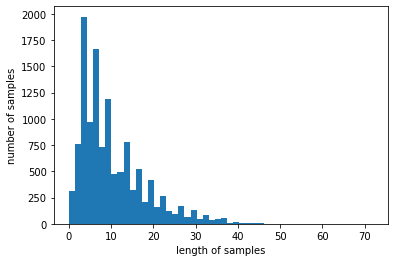

In [31]:
# 패딩 전 벡터의 길이 분포 파악 --> 대부분 5~15 정도의 크기를 가짐
print('문장의 최대 길이 : {}'.format(max(len(l) for l in train_x)))
print('문장의 평균 길이 : {}'.format(sum(map(len, train_x))/len(train_x)))
plt.hist([len(s) for s in train_x], bins=50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

In [32]:
# 데이터 패딩
max_len = 20
# 패딩 사이즈
train_x = pad_sequences(train_x, maxlen=max_len)
# 훈련 데이터 패딩
test_x = pad_sequences(test_x, maxlen=max_len)
# 테스트 데이터 패딩

Class=0, n=6625 (33.333%)
Class=1, n=6625 (33.333%)
Class=2, n=6625 (33.333%)


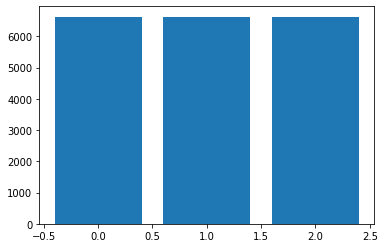

In [33]:
# 데이터 불균형 해결을 위한 오버샘플링 기법 - SMOTE
from imblearn.over_sampling import SMOTE
train_x, train_y = SMOTE(random_state=0).fit_resample(train_x, train_y)
count_and_plot(train_y)

In [34]:
# target data one hot encoding
train_y = to_categorical(train_y)
test_y = to_categorical(test_y)

In [35]:
# 모델 평가 함수 정의
def get_eval(y_test, pred):
    accuracy = accuracy_score(y_test, pred)
    precision = precision_score(y_test, pred)
    recall = recall_score(y_test, pred)
    f1_score = f1_score(y_test,pred)
    return accuracy, precision, recall, f1_score

##Bidirectional LSTM model

In [36]:
from tensorflow.keras.layers import Dense, SimpleRNN, LSTM, Embedding, Dropout
from tensorflow.keras.layers import Input, LSTM, Bidirectional, Concatenate
from keras.callbacks import EarlyStopping

In [37]:
# 바다나우 어텐션 정의

class BahdanauAttention(tf.keras.Model):
  def __init__(self, units):
    super(BahdanauAttention, self).__init__()
    self.W1 = Dense(units)
    self.W2 = Dense(units)
    self.V = Dense(1)

  def call(self, values, query): # 단, key와 value는 같음
    # query shape == (batch_size, hidden size)
    # hidden_with_time_axis shape == (batch_size, 1, hidden size)
    # score 계산을 위해 뒤에서 할 덧셈을 위해서 차원 변경
    hidden_with_time_axis = tf.expand_dims(query, 1)

    # score shape == (batch_size, max_length, 1)
    # we get 1 at the last axis because we are applying score to self.V
    # the shape of the tensor before applying self.V is (batch_size, max_length, units)
    score = self.V(tf.nn.tanh(
        self.W1(values) + self.W2(hidden_with_time_axis)))

    # attention_weights shape == (batch_size, max_length, 1)
    attention_weights = tf.nn.softmax(score, axis=1)

    # context_vector shape after sum == (batch_size, hidden_size)
    context_vector = attention_weights * values
    context_vector = tf.reduce_sum(context_vector, axis=1)

    return context_vector, attention_weights

In [38]:
# bidirectional LSTM model 설계
sequence_input = Input(shape=(max_len,), dtype='int32')
embedded_sequences = Embedding(num_words, 128, input_length=max_len, mask_zero = True)(sequence_input)
lstm = Bidirectional(LSTM(64, dropout=0.5, recurrent_dropout = 0.5, return_sequences = True))(embedded_sequences)
lstm, forward_h, forward_c, backward_h, backward_c = Bidirectional \
  (LSTM(64, dropout=0.5, recurrent_dropout = 0.5, return_sequences=True, return_state=True))(lstm)


In [39]:
print(lstm.shape, forward_h.shape, forward_c.shape, backward_h.shape, backward_c.shape)

(None, 20, 128) (None, 64) (None, 64) (None, 64) (None, 64)


In [40]:
state_h = Concatenate()([forward_h, backward_h]) 
# 은닉 상태
state_c = Concatenate()([forward_c, backward_c]) 
# 셀 상태

In [41]:
attention = BahdanauAttention(64) 
# 가중치 크기 정의
context_vector, attention_weights = attention(lstm, state_h)

In [42]:
dense1 = Dense(40, activation="relu")(context_vector) #40
dropout = Dropout(0.5)(dense1)
output = Dense(3, activation="softmax")(dropout)
model = models.Model(inputs=sequence_input, outputs=output)
# 모델 설정

In [43]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 20)]         0           []                               
                                                                                                  
 embedding (Embedding)          (None, 20, 128)      1024000     ['input_1[0][0]']                
                                                                                                  
 bidirectional (Bidirectional)  (None, 20, 128)      98816       ['embedding[0][0]']              
                                                                                                  
 bidirectional_1 (Bidirectional  [(None, 20, 128),   98816       ['bidirectional[0][0]']          
 )                               (None, 64),                                                  

In [44]:
#optimizer = optimizers.SGD(momentum=0.9)
model.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['acc'])

In [45]:
# 모델 학습
es = EarlyStopping (monitor = 'val_loss', mode = 'min', patience = 4)
learn = model.fit(train_x, train_y, epochs = 100, batch_size = 64, 
                  callbacks = [es],validation_split = 0.2)

Epoch 1/100
249/249 [==============================] - 76s 238ms/step - loss: 0.9434 - acc: 0.5762 - val_loss: 2.3196 - val_acc: 5.0314e-04
Epoch 2/100
249/249 [==============================] - 59s 236ms/step - loss: 0.7691 - acc: 0.6752 - val_loss: 2.4149 - val_acc: 0.0138
Epoch 3/100
249/249 [==============================] - 76s 306ms/step - loss: 0.6412 - acc: 0.7377 - val_loss: 2.9739 - val_acc: 0.0458
Epoch 4/100
249/249 [==============================] - 58s 234ms/step - loss: 0.5315 - acc: 0.7975 - val_loss: 2.9649 - val_acc: 0.1273
Epoch 5/100
249/249 [==============================] - 59s 237ms/step - loss: 0.4406 - acc: 0.8394 - val_loss: 3.3204 - val_acc: 0.1268


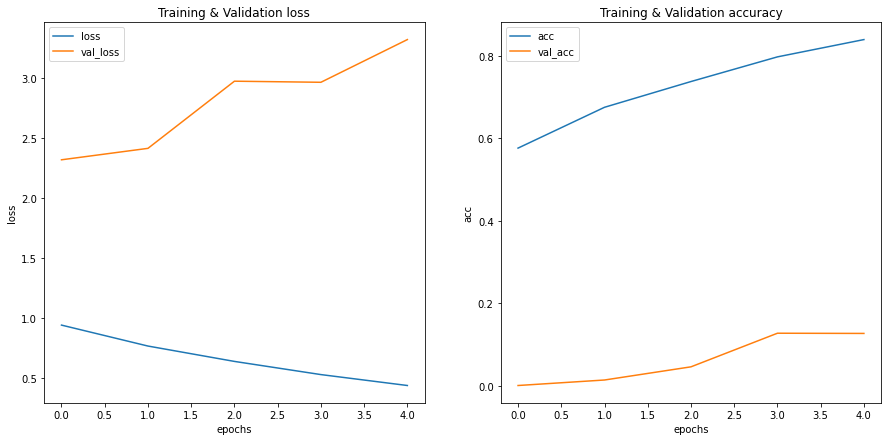

In [46]:
plt.figure(figsize=(15,7))
# 그래프의 크기
plt.subplot(1, 2, 1)
# (1, 2) 중 첫번째 그래프
plt.title('Training & Validation loss')
# 그래프의 타이틀
plt.plot(learn.history['loss'], label='loss')
# 선그래프 그리기
plt.plot(learn.history['val_loss'], label='val_loss')
# 선그래프 그리기
plt.xlabel('epochs')
# x축 라벨
plt.ylabel('loss')
# y축 라벨
plt.legend()
# 그리기에서의 label과 색, 모양을 기준으로 범례를 생성함
plt.subplot(1,2,2)
# (1, 2) 중 두번째 그래프
plt.title('Training & Validation accuracy')
# 그래프의 타이틀
plt.plot(learn.history['acc'],label='acc')
# 선그래프 그리기
plt.plot(learn.history['val_acc'],label='val_acc')
# 선그래프 그리기
plt.xlabel('epochs')
# x축 라벨
plt.ylabel('acc')
# y축 라벨
plt.legend()
# 그리기에서의 label과 색, 모양을 기준으로 범례를 생성함
plt.show()
# 출력

117/117 [==============================] - 3s 24ms/step - loss: 0.9591 - acc: 0.6591


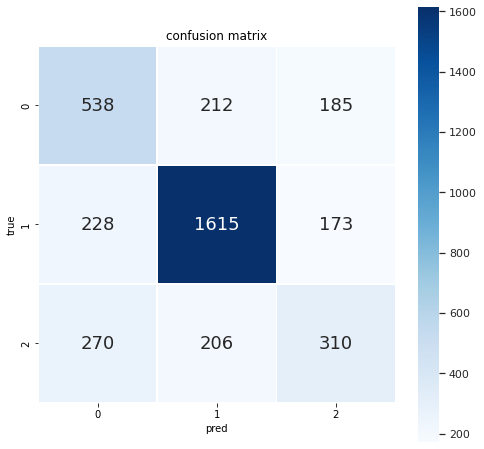

In [47]:
evaluate = model.evaluate(test_x, test_y)
# 모델의 손실 함수를 기준으로 평가함
pred = model.predict(test_x)
# 모델의 예측값
pred = np.argmax(pred, axis=1)
#  One Hot Encoding에서 범주형으로 변환
true = np.argmax(test_y, axis=1)
#  One Hot Encoding에서 범주형으로 변환
matrix = confusion_matrix(true, pred, labels=range(3))
# 실제값과 예측값 사이의 컨퓨젼 행렬
df = pd.DataFrame(matrix, columns=range(3), index=range(3))
# 히트맵을 그리기 위해 데이터프레임 형태로 변환
plt.figure(figsize=(8, 8))
# 그래프의 크기
plt.title('confusion matrix')
# 그래프의 타이틀
plt.rcParams['axes.unicode_minus'] = False
# unicode minus를 사용하지 않기 위한 설정 (minus 깨짐현상 방지)
plt.rcParams['font.family'] = 'NanumGothic'
# 폰트 글꼴 설정
sns.set(font_scale=1.0)
# 폰트 사이즈 설정
sns.heatmap(df, annot=True, fmt='d', square=True, cmap='Blues',linewidths=.5,annot_kws={"size": 18})
# 히트맵 그리기
plt.xlabel('pred')
# x축 라벨
plt.ylabel('true')
# y축 라벨
plt.show()
# 출력

In [48]:
print(classification_report(true, pred))

              precision    recall  f1-score   support

           0       0.52      0.58      0.55       935
           1       0.79      0.80      0.80      2016
           2       0.46      0.39      0.43       786

    accuracy                           0.66      3737
   macro avg       0.59      0.59      0.59      3737
weighted avg       0.66      0.66      0.66      3737



##CNN 

In [49]:
# 다수의 커널을 사용할 경우에는 Funtional API를 사용
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Embedding, Dropout, Conv1D, GlobalMaxPooling1D, Dense, Input, Flatten, Concatenate, MaxPooling1D
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.models import load_model

In [50]:
embedding_dim = 128
dropout_prob = (0.5, 0.5) #임베딩 층 이후에는 50% 드롭아웃
num_filters = 128

In [51]:
vocab_size=8000
model_input = Input(shape = (max_len,)) 
z = Embedding(vocab_size, embedding_dim, input_length = max_len, name="embedding", mask_zero=True)(model_input)
# 단어 집합의 크기(vocab_size) : 19416
z = Dropout(dropout_prob[0])(z)

In [52]:
conv_blocks =[]

for sz in [2,3,4]:
    conv = Conv1D(filters = num_filters, 
                  kernel_size = sz,
                  padding = 'valid',
                  activation = 'relu',
                  strides = 1)(z)
    conv = GlobalMaxPooling1D()(conv) #maxpooling
    conv = Flatten()(conv)
    conv_blocks.append(conv)

In [53]:
# 각각 maxpooling한 결과를 연결(concatenate) 한다.
z = Concatenate()(conv_blocks) if len(conv_blocks) > 1 else conv_blocks[0]
z = Dropout(dropout_prob[1])(z)
z = Dense(128, activation="relu")(z)
model_output = Dense(3, activation="softmax")(z)

cnn_model = Model(model_input, model_output)
cnn_model.compile(loss = 'categorical_crossentropy', optimizer = 'rmsprop', metrics=['acc'])

In [54]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=4)
mc = ModelCheckpoint('CNN_model.h5', monitor='val_acc', mode='max', verbose=1, save_best_only=True)

history = cnn_model.fit(train_x, train_y, batch_size = 64, epochs=10, validation_split=0.2, callbacks=[es])

Epoch 1/10
249/249 [==============================] - 12s 43ms/step - loss: 0.9130 - acc: 0.5897 - val_loss: 1.7131 - val_acc: 0.0000e+00
Epoch 2/10
249/249 [==============================] - 10s 42ms/step - loss: 0.7971 - acc: 0.6467 - val_loss: 2.3555 - val_acc: 0.0556
Epoch 3/10
249/249 [==============================] - 10s 42ms/step - loss: 0.7251 - acc: 0.6879 - val_loss: 2.2632 - val_acc: 0.1203
Epoch 4/10
249/249 [==============================] - 12s 47ms/step - loss: 0.6676 - acc: 0.7235 - val_loss: 2.2908 - val_acc: 0.1316
Epoch 5/10
249/249 [==============================] - 11s 42ms/step - loss: 0.6113 - acc: 0.7559 - val_loss: 2.1131 - val_acc: 0.1404
Epoch 5: early stopping


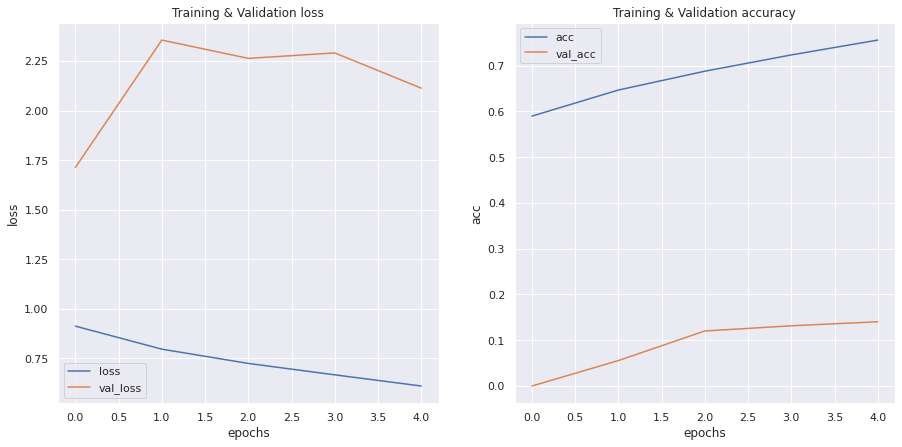

In [55]:
plt.figure(figsize=(15,7))
# 그래프의 크기
plt.subplot(1, 2, 1)
# (1, 2) 중 첫번째 그래프
plt.title('Training & Validation loss')
# 그래프의 타이틀
plt.plot(history.history['loss'], label='loss')
# 선그래프 그리기
plt.plot(history.history['val_loss'], label='val_loss')
# 선그래프 그리기
plt.xlabel('epochs')
# x축 라벨
plt.ylabel('loss')
# y축 라벨
plt.legend()
# 그리기에서의 label과 색, 모양을 기준으로 범례를 생성함
plt.subplot(1,2,2)
# (1, 2) 중 두번째 그래프
plt.title('Training & Validation accuracy')
# 그래프의 타이틀
plt.plot(history.history['acc'],label='acc')
# 선그래프 그리기
plt.plot(history.history['val_acc'],label='val_acc')
# 선그래프 그리기
plt.xlabel('epochs')
# x축 라벨
plt.ylabel('acc')
# y축 라벨
plt.legend()
# 그리기에서의 label과 색, 모양을 기준으로 범례를 생성함
plt.show()
# 출력

117/117 [==============================] - 1s 6ms/step - loss: 0.6956 - acc: 0.7043


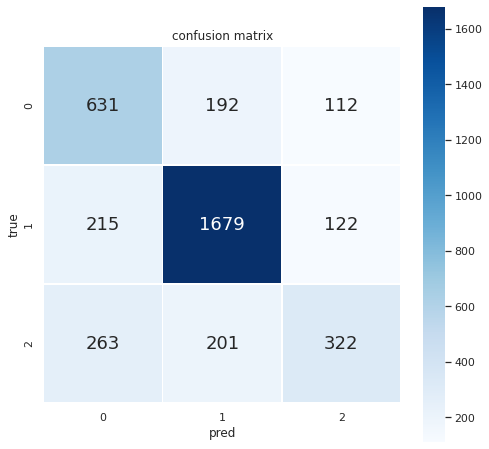

In [56]:
evaluate = cnn_model.evaluate(test_x, test_y)
# 모델의 손실 함수를 기준으로 평가함
pred = cnn_model.predict(test_x)
# 모델의 예측값
pred = np.argmax(pred, axis=1)
#  One Hot Encoding에서 범주형으로 변환
true = np.argmax(test_y, axis=1)
#  One Hot Encoding에서 범주형으로 변환
matrix = confusion_matrix(true, pred, labels=range(3))
# 실제값과 예측값 사이의 컨퓨젼 행렬
df = pd.DataFrame(matrix, columns=range(3), index=range(3))
# 히트맵을 그리기 위해 데이터프레임 형태로 변환
plt.figure(figsize=(8, 8))
# 그래프의 크기
plt.title('confusion matrix')
# 그래프의 타이틀
plt.rcParams['axes.unicode_minus'] = False
# unicode minus를 사용하지 않기 위한 설정 (minus 깨짐현상 방지)
plt.rcParams['font.family'] = 'NanumGothic'
# 폰트 글꼴 설정
sns.set(font_scale=1.0)
# 폰트 사이즈 설정
sns.heatmap(df, annot=True, fmt='d', square=True, cmap='Blues',linewidths=.5,annot_kws={"size": 18})
# 히트맵 그리기
plt.xlabel('pred')
# x축 라벨
plt.ylabel('true')
# y축 라벨
plt.show()
# 출력

In [57]:
print(classification_report(true, pred))

              precision    recall  f1-score   support

           0       0.57      0.67      0.62       935
           1       0.81      0.83      0.82      2016
           2       0.58      0.41      0.48       786

    accuracy                           0.70      3737
   macro avg       0.65      0.64      0.64      3737
weighted avg       0.70      0.70      0.70      3737

